#Setup

In [12]:
!git init
!git remote add origin https://github.com/sgerloff/sustainable_deepfashion.git
!git pull origin main
!pip install -r requirements.txt

!make setup-preprocessed-gc CATEGORY_ID=1 MIN_PAIR_COUNT=20

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/sgerloff/sustainable_deepfashion
 * branch            main       -> FETCH_HEAD
   88e3067..beee1f7  main       -> origin/main
Updating 88e3067..beee1f7
Fast-forward
 src/models/learning_rate_estimator.py | 19 ++++++++++++-------
 1 file changed, 12 insertions(+), 7 deletions(-)
python -m src.google_colab_utility connect_gdrive
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
unzip /gdrive/MyDrive/deepfashion_gc_save/preprocessed_cat_1.zip
Archive:  /gdrive/MyDrive/deepfashion_gc_save/preprocessed_cat_1.zip
replace data/processed/train/cat1/042979_3393.jpg? [y]es, [n]o, [A]ll, [N]one,

#Learning Rate Estimation

In [2]:
# !wget http://d2fcl18pl6lkip.cloudfront.net/models/effnet_freeze_basemodel.h5 -O models/effnet_freeze_basemodel.h5 

In [13]:
from src.instruction_utility import *

instruction_parser = InstructionParser("efficientnetb0_frozen.json")
train_df = load_dataframe(instruction_parser.instruction["train_data"]["dataframe"])

In [14]:
from src.models.learning_rate_estimator import LearningRateEstimator

model = instruction_parser.get_model()
model.compile(
    loss=instruction_parser.get_loss(),
    optimizer=instruction_parser.get_optimizer()
)

dataset = instruction_parser.get_train_dataset().repeat()

steps_per_epoch = train_df["pair_id"].nunique()

lrf = LearningRateEstimator()
lrf.find(model, dataset, 1e-10, 1e0, steps_per_epoch=steps_per_epoch)
lrf.plot_loss()

TypeError: ignored

Load model from /content/models/effnet_freeze_basemodel.h5
Epoch 1/3
912/912 [==============================] - 259s 241ms/step - loss: 0.9451 - score: 0.0000e+00
Epoch 2/3
912/912 [==============================] - 219s 240ms/step - loss: 0.9401 - score: 0.0000e+00
Epoch 3/3
912/912 [==============================] - 217s 238ms/step - loss: 0.8150 - score: 0.0000e+00


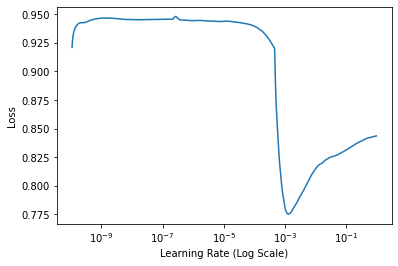

In [ ]:
from src.models.learning_rate_estimator import LearningRateEstimator
from src.models.efficient_net_triplet import EfficientNetTriplet
from src.utility import get_project_dir
import joblib, os

effnet_triplet = EfficientNetTriplet()
effnet_triplet.load("effnet_freeze_basemodel.h5")
effnet_triplet.set_basemodel_freeze_ratio(0.5)

train_df = joblib.load(os.path.join(get_project_dir(),
                                    "data",
                                    "processed",
                                    "category_id_1_deepfashion_train.joblib"))

lrf = LearningRateEstimator(effnet_triplet.model)

dataset, train_size = effnet_triplet.get_dataset(train_df, batch_size=32, training_ratio=1.)

lrf.find( dataset, 1e-10, 1e0, steps_per_epoch=train_size )
lrf.plot_loss()